In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
test_name = 'anomaly5_FL_5epochs'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

anom_clients = [0,1,2,3,4]

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/synthetic/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2', 'anomaly3']

    data = pd.read_csv(file,
                    names = names)
    
    data['client_anom'] = data['cid'].apply(lambda x: 1 if x in anom_clients else 0)
    
    datas.append(data)

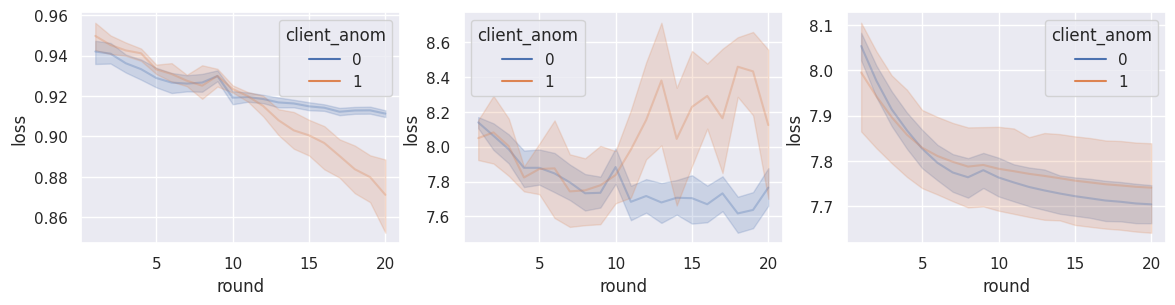

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i], hue='client_anom', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

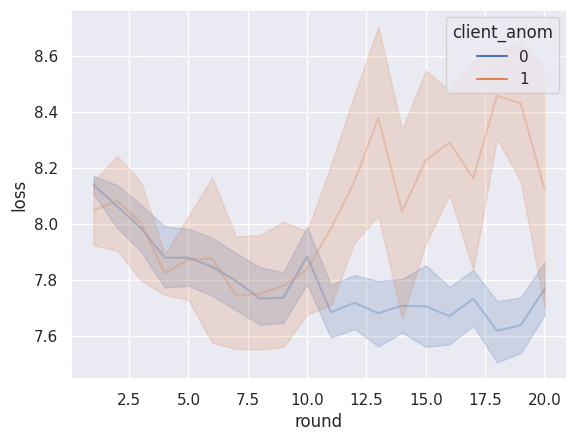

In [5]:
sns.lineplot(datas[1], x = 'round', y = 'loss', hue='client_anom', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

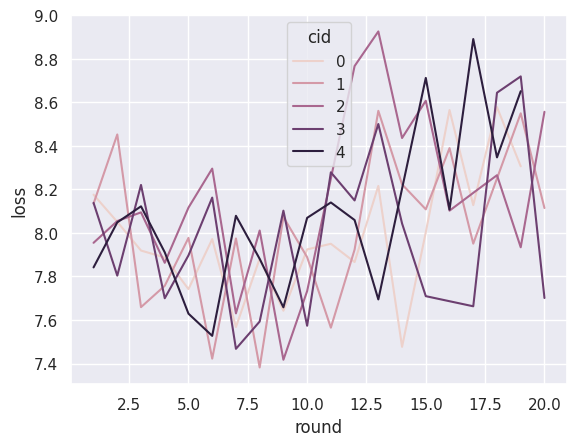

In [6]:
sns.lineplot(datas[1][datas[1]['cid'].isin( [0,1,2,3,4])], x = 'round', y = 'loss', hue = 'cid')

In [11]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    cids = [0,1,2,3,4]

    #df['true_anomaly'] = df['round'].apply(lambda x: 1 if x>=10 else 0)
    #idx = df[df['cid'].isin(cids)].index.values[0] 
    #df.at[idx, 'true_anomaly']= 1
    df['true_anomaly'] = 0
    df.loc[(df['cid'].isin(cids)*df['round'].isin([10,11])), ['true_anomaly']] = 1

    th = 1.5

    for cid in range(15):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['loss'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly',f1_score(data['true_anomaly'], data['anomaly']),
        precision_score(       data['true_anomaly'], data['anomaly']),
        recall_score(          data['true_anomaly'], data['anomaly']),
        accuracy_score(        data['true_anomaly'], data['anomaly']))

    print('Anomaly2',f1_score(data['true_anomaly'], data['anomaly2']),
        precision_score(       data['true_anomaly'], data['anomaly2']),
        recall_score(          data['true_anomaly'], data['anomaly2']),
        accuracy_score(        data['true_anomaly'], data['anomaly2']))

    print('Anomaly3',f1_score(data['true_anomaly'],  data['anomaly3']),
        precision_score(       data['true_anomaly'], data['anomaly3']),
        recall_score(          data['true_anomaly'], data['anomaly3']),
        accuracy_score(        data['true_anomaly'], data['anomaly3']))
    
    print('Anomaly32',f1_score(data['true_anomaly'], data['anomaly32']),
        precision_score(       data['true_anomaly'], data['anomaly32']),
        recall_score(          data['true_anomaly'], data['anomaly32']),
        accuracy_score(        data['true_anomaly'], data['anomaly32']))
    
    
    print('-----------')


Anomaly 0.0 0.0 0.0 0.984375
Anomaly2 0.0 0.0 0.0 0.9704861111111112
Anomaly3 0.04477611940298507 0.024 0.3333333333333333 0.7777777777777778
Anomaly32 0.04411764705882353 0.023622047244094488 0.3333333333333333 0.7743055555555556
-----------
Anomaly 0.0 0.0 0.0 0.9846938775510204
Anomaly2 0.1290322580645161 0.09090909090909091 0.2222222222222222 0.9540816326530612
Anomaly3 0.11267605633802817 0.06015037593984962 0.8888888888888888 0.7857142857142857
Anomaly32 0.10596026490066225 0.056338028169014086 0.8888888888888888 0.7704081632653061
-----------
Anomaly 0.0 0.0 0.0 0.9833333333333333
Anomaly2 0.0 0.0 0.0 0.9683333333333334
Anomaly3 0.11320754716981132 0.06040268456375839 0.9 0.765
Anomaly32 0.1111111111111111 0.05921052631578947 0.9 0.76
-----------


In [8]:
data['anomaly'].value_counts()

0    600
Name: anomaly, dtype: int64

In [9]:
data[data['round'] == 11]

,cid,round,loss,diff,anomaly,anomaly2,anomaly3,client_anom,anomaly12,true_anomaly,anomaly32
300,6,11,7.815875,0.130951,0,0,1,0,0,0,1
301,0,11,7.884027,0.199103,0,0,0,1,0,1,0
302,13,11,7.512650,0.303225,0,0,1,0,0,0,1
303,12,11,7.779196,0.104830,0,0,0,0,0,0,0
304,25,11,7.677044,0.206983,0,0,0,0,0,0,0
305,4,11,7.640048,0.139148,0,0,1,1,0,1,1
306,1,11,7.681550,0.004506,0,0,1,1,0,1,1
307,23,11,7.912308,0.230757,0,0,0,0,0,0,0
308,9,11,7.796179,0.114629,0,0,1,0,0,0,1
309,2,11,7.771223,0.024956,0,0,1,1,0,1,1


In [10]:
#testar sem parar o treinamento dos clientes anomalos
#testar usando outras anomalias
#testar sem anomalias